[NCP Example](https://github.com/mlech26l/keras-ncp)

# Stack NCP with other types of layers


In [1]:
# Install dependencies if they are not installed yet
!pip install -U tensorflow seaborn keras-ncp

In [2]:
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
import kerasncp as kncp
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns

## Preparing the dataset

The dataset we are using considers the task of maneuvering a mobile robot to avoid obstacles in its path.
Input data is obtained from a [Sick LMS 1xx laser rangefinder (LiDAR)](https://www.sick.com/ag/en/detection-and-ranging-solutions/2d-lidar-sensors/lms1xx/c/g91901) mounted on the robot. Output variable is the steering direction as a variable in the range [-1,+1], i.e., -1 corresponding to turning left, 0 going straight, and +1 to turning right.
Supervised training data was collected by manually steering the robot around the obstacles on 29 different tracks.

![collision_avoidance.png](https://github.com/mlech26l/icra_lds/raw/master/robot_small.png)

First, we will download the dataset.

In [3]:
# Download the dataset (already implemented in keras-ncp)
(x_train, y_train), (x_valid, y_valid) = kncp.datasets.icra2020_lidar_collision_avoidance.load_data()
print("x_train", str(x_train.shape))
print("y_train", str(y_train.shape))

x_train (678, 32, 541, 1)
y_train (678, 32, 1)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [4]:
x_train[0][0].shape

(541, 1)

Note that there is no **test-set**. We are dealing here with a robotic control task were each action influences the future observations, which is very different from a *classify-and-forget* setting used in image classification tasks. 

The environment feedback cannot be adequatly model during supervised training, so instead of evaluating the model on a test-set, we would need to **test the model live on the robot** to measure its performance.

Consequently, we will just monitor the metrics on the **validation-set** to give us some rough estimation of how well the model would perform in reality.

Anyways, let's plot a few samples of the training set to understand what problem we are dealing with here

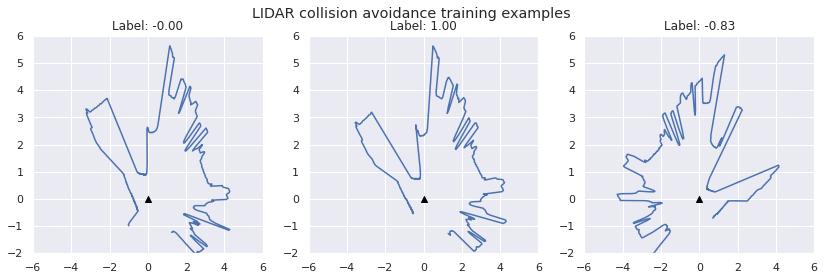

In [5]:
# Note: this plot is centered at the location of the robot, i.e. the robot is always at coordinates: (0,0). 
def plot_lidar(lidar,ax):
  # Helper function for plotting polar-based lidar data
  angles = np.linspace(-2.35,2.35,len(lidar))   # this is equivalent to a scan angle: (-135,+135); len(lidar)=541, which is the number of points sampled within this angle range.
  x = lidar*np.cos(angles)
  y = lidar*np.sin(angles)
  ax.plot(y,x)
  ax.scatter([0],[0],marker="^",color="black")
  ax.set_xlim((-6,6))
  ax.set_ylim((-2,6))
  

sns.set()
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
plot_lidar(x_train[0,0,:,0],ax1)
plot_lidar(x_train[0,12,:,0],ax2)
plot_lidar(x_train[20,0,:,0],ax3)
ax1.set_title("Label: {:0.2f}".format(y_train[0,0,0]))
ax2.set_title("Label: {:0.2f}".format(y_train[0,12,0]))
ax3.set_title("Label: {:0.2f}".format(y_train[20,0,0]))
fig.suptitle("LIDAR collision avoidance training examples")
fig.show()

## Bulding a stacked-NCP model

Here, we will create a neural network consisting of a feed-forward followed by a recurrent sub-model:

![wirings.png](https://github.com/mlech26l/keras-ncp/blob/master/misc/ncp_cnn.png?raw=true)

The input data are provided as a time-series where at each time-step we observe a full laser rangefinder scan. The network then feeds the LIDAR scan through the feedforward part to obtain a 32-dimensional latent representation of the current input. The recurrent NCP then takes this latant feature as input and updates its internal state and output prediction.


In [6]:
N = x_train.shape[2]  # N = 541  per (678, 32, 541, 1)
channels = x_train.shape[3] # channels = 1  per (678, 32, 541, 1)

wiring = kncp.wirings.NCP(
    inter_neurons=12,  # Number of inter neurons
    command_neurons=8,  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=4,  # How many outgoing synapses has each sensory neuron
    inter_fanout=4,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=4,  # How many recurrent synapses are in the
    # command neuron layer
    motor_fanin=6,  # How many incomming syanpses has each motor neuron
)
rnn_cell = LTCCell(wiring)

# We need to use the TimeDistributed layer to independently apply the
# Conv1D/MaxPool1D/Dense over each time-step of the input time-series.
model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, N, channels)),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(18, 5, strides=3, activation="relu")
        ),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(20, 5, strides=2, activation="relu")   # see what happens if changing strides = 1
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(22, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(24, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),    # See what happens without this max pooling layer.
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.TimeDistributed(keras.layers.Dense(32, activation="relu")),
        keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss="mean_squared_error",
)

model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
time_distributed (TimeDistributed)           (None, None, 179, 18)                   108            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)         (None, None, 88, 20)                    1820           
____________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)         (None, None, 44, 20)                    0              
____________________________________________________________________________________________________
time_distributed_3 (TimeDistributed)         (None, None, 40, 22)                    2222           
_______________________________________________________________________

Let's draw the NCP wiring of our model

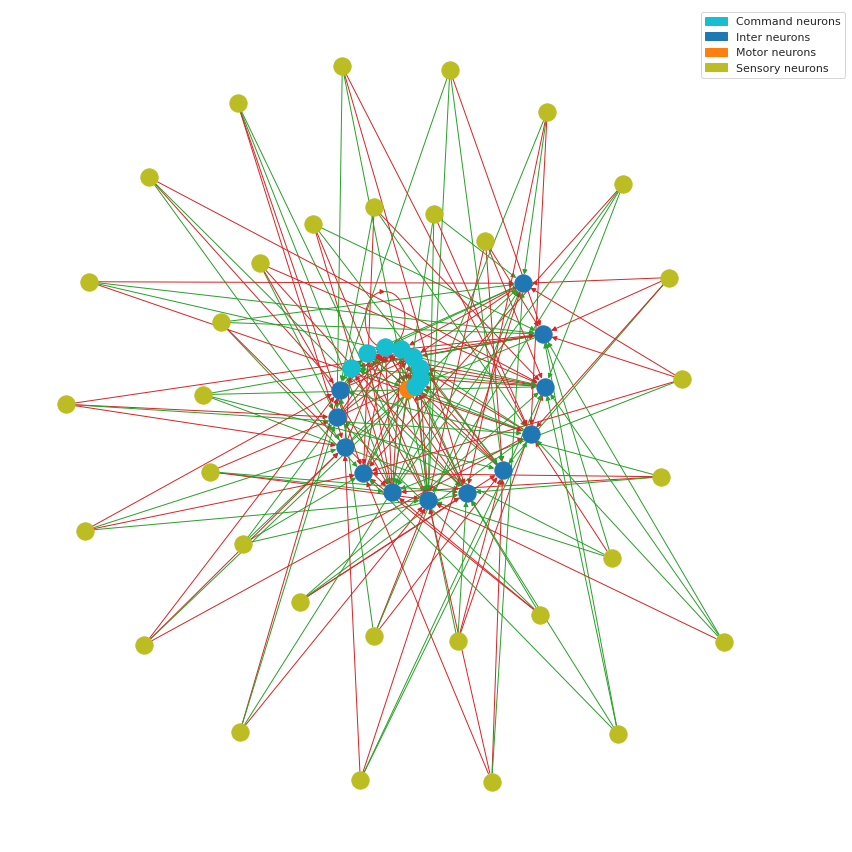

In [7]:
sns.set_style("white")
plt.figure(figsize=(12, 12))
legend_handles = rnn_cell.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

## Training the stacked-NCP model

Before training the model, we first evaluate how well it performs on the validation set

In [8]:
model.evaluate(x_valid, y_valid)

8/8 [==============================] - 16s 32ms/step - loss: 0.2437


0.24374158680438995

In [9]:
model.fit(
    x=x_train, y=y_train, batch_size=64, epochs=20, validation_data=(x_valid, y_valid)
)

Epoch 1/20
11/11 [==============================] - 15s 587ms/step - loss: 0.2054 - val_loss: 0.1587
Epoch 2/20
11/11 [==============================] - 6s 570ms/step - loss: 0.1762 - val_loss: 0.1487
Epoch 3/20
11/11 [==============================] - 6s 563ms/step - loss: 0.1552 - val_loss: 0.1242
Epoch 4/20
11/11 [==============================] - 7s 599ms/step - loss: 0.1403 - val_loss: 0.1129
Epoch 5/20
11/11 [==============================] - 6s 577ms/step - loss: 0.1302 - val_loss: 0.1161
Epoch 6/20
11/11 [==============================] - 6s 544ms/step - loss: 0.1343 - val_loss: 0.1182
Epoch 7/20
11/11 [==============================] - 6s 557ms/step - loss: 0.1342 - val_loss: 0.1088
Epoch 8/20
11/11 [==============================] - 6s 549ms/step - loss: 0.1249 - val_loss: 0.1131
Epoch 9/20
11/11 [==============================] - 6s 567ms/step - loss: 0.1202 - val_loss: 0.1053
Epoch 10/20
11/11 [==============================] - 6s 539ms/step - loss: 0.1157 - val_loss: 0.117

Now let's evaluate the performance of our model on the validation set after the training

In [10]:
model.evaluate(x_valid, y_valid)

8/8 [==============================] - 0s 29ms/step - loss: 0.1149


0.11494012176990509